@todo: batch effects from the 

# 0. Load data

In [3]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

# Suppress batch effects
def scale_by_region(df):
    scaled = []
    for region,_df in df.groupby('Region'):
        _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
        _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
                           data=_X)
        _df['Region'] = region
        scaled.append(_df)
    return pd.concat(scaled)
    

### Separate measurement fields into constituent types

In [8]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Morphology differences'

all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
divisions_12h = pd.read_pickle(path.join(dataset_dir,f'divisions_12h.pkl'))
divisions_24h = pd.read_pickle(path.join(dataset_dir,f'divisions_24h.pkl'))
divisions_36h = pd.read_pickle(path.join(dataset_dir,f'divisions_36h.pkl'))
divisions_48h = pd.read_pickle(path.join(dataset_dir,f'divisions_48h.pkl'))
divisions_56h = pd.read_pickle(path.join(dataset_dir,f'divisions_56h.pkl'))
divisions_60h = pd.read_pickle(path.join(dataset_dir,f'divisions_60h.pkl'))
divisions_72h = pd.read_pickle(path.join(dataset_dir,f'divisions_72h.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))


In [30]:
from functools import reduce

measurement_types = divisions.columns.get_level_values(1)

#Intrinsics
shapes = basals.columns[ (measurement_types.str.contains('shape') | measurement_types.str.contains('shcoeff'))
                         & ~measurement_types.str.contains('adjac') & ~measurement_types.str.contains('elative')]
drop = [f for f in shapes if 'Manual' in f[0]]
shapes = shapes.drop(drop)

position = basals.columns[(measurement_types == 'Measurement cell position')]
h2b = basals.columns[(measurement_types == 'Measurement H2B') | (measurement_types == 'Measurement H2B rate')]
fucci = basals.columns[(measurement_types == 'Measurement FUCCI') | (measurement_types == 'Measurement FUCCI rate')]
intrinsic_features = reduce(list.__add__, [f.tolist() for f in [shapes,position,h2b,fucci]])

# Environment
tissue_geom = basals.columns[measurement_types.str.contains('Measurement tissue geometry')]
collagen = basals.columns[measurement_types.str.contains('ollagen')]
tissue_topo = basals.columns[measurement_types.str.contains('topology')]
adjac_shape = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('shape'))
                | (measurement_types.str.contains('adjac') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in adjac_shape if 'Manual' in f[0]]
adjac_shape = adjac_shape.drop(drop)

adjac_fucci = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('FUCCI'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('FUCCI'))]
adjac_h2b = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('H2B'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('H2B'))]
relative_shape = basals.columns[(measurement_types.str.contains('relative') & measurement_types.str.contains('shape'))
                                 | (measurement_types.str.contains('relative') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in relative_shape if 'Manual' in f[0] or 'rate' in f[0]]
relative_shape = relative_shape.drop(drop)

extrinsic_features = reduce(list.__add__, [f.tolist() for f in [tissue_geom,collagen,tissue_topo,adjac_shape,adjac_fucci,adjac_h2b,relative_shape]])

#Other
times = basals.columns[measurement_types == 'Measurement time']
metas = basals.columns[measurement_types == 'Meta']

accounted_for = set(intrinsic_features).union(set(extrinsic_features)).union(metas).union(times)
set(basals.columns) - accounted_for

{('Diff from Max adjac Manual cell volume at 1 frame prior',
  'Measurement cell shape adjac diff'),
 ('Diff from Mean adjac Manual cell volume at 1 frame prior',
  'Measurement cell shape adjac diff'),
 ('Diff from Median adjac Manual cell volume at 1 frame prior',
  'Measurement cell shape adjac diff'),
 ('Diff from Min adjac Manual cell volume at 1 frame prior',
  'Measurement cell shape adjac diff'),
 ('Diff from Std adjac Manual cell volume at 1 frame prior',
  'Measurement cell shape adjac diff'),
 ('G1 duration time', 'Measurement'),
 ('Manual cell volume', 'Measurement cell shape'),
 ('Max adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Mean adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Median adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Min adjac Manual cell volume', 'Measurement cell shape adjac'),
 ('Region', ''),
 ('Relative Cell volume G1 only exponential growth rate',
  'Measurement cell shape rate relative'),
 ('Relative 

In [31]:
# Standardize

extrinsic_measurements = divisions[extrinsic_features]
features2drop = extrinsic_measurements.columns[extrinsic_measurements.isna().sum() > 200]
extrinsic_measurements = extrinsic_measurements.drop(columns=features2drop)
extrinsic_measurements = extrinsic_measurements.dropna(axis=0)
extrinsic_measurements['Region'] = basals['Region']

meas_scaled_by_region = scale_by_region(extrinsic_measurements)
scaled_data = meas_scaled_by_region.dropna(axis=0)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact 

In [32]:
print(len(extrinsic_measurements))
extrinsic_measurements.isna().sum()

585


BM height                                                       Measurement tissue geometry                0
Height to BM                                                    Measurement tissue geometry                0
Mean curvature - cell coords                                    Measurement tissue geometry                0
Gaussian curvature - cell coords                                Measurement tissue geometry                0
Mean curvature 2um                                              Measurement tissue geometry                0
                                                                                                          ..
Diff from Relative Middle area at 1 frame prior                 Measurement cell shape relative diff       0
Diff from Relative Apical area at 1 frame prior                 Measurement cell shape relative diff       0
Diff from Relative cyto_shcoeffs_surface_area at 1 frame prior  Measurement shcoeff relative diff          0
Diff from Relative 

# 1. U-map

[https://github.com/CoAxLab/pycombat]
These input data consist of the following ingredients:

    Y: The matrix of response variables, with dimensions [observations x features]
    b: The array of batch label for each observation. In principle these could be labelled as numbers or strings.
    X: The matrix of effects of interest to keep, with dimensions [observations x features_interest]
    C: The matrix of covariates to remove, with dimensions [observations x features_covariates]


### Try a bunch of hyperparameters

In [19]:
pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)

BM height                Height to BM  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     R1_2                       0.402767                    1.752485   
      R1_11                      0.402767                    1.687356   
      R1_19                      1.173684                    1.586938   
      R1_24                      0.402767                    1.401405   
      R1_27                      1.173684                    1.143118   
...                                   ...                         ...   
14    R2_1134                    1.288418                    2.228199   
      R2_1144                   -0.678377                    1.376517   
      R2_1149                    1.288418                   -0.943320   
      R2_1155                    2.075136                    1.169778   
      R2_1156                    2.075136                   -0.249854   

              Mean curvature - cell coords Gaussian curvature - cell coords  \
               Measurement tissue geometry      Measurement tissue geometry   
Frame TrackID                                                                 
0     R1_2                       -1.916181                        -0.663436   
      R1_11                      -1.850074                        -0.101735   
      R1_19                      -1.538689                        -0.135102   
      R1_24                      -1.158762                        -0.305782   
      R1_27                      -1.728106                        -0.265036   
...                                    ...                              ...   
14    R2_1134                    -0.996835                         0.205136   
      R2_1144                     4.307986                        -0.909162   
      R2_1149                    -0.619393                         0.366192   
      R2_1155                    -0.354119                         0.847656   
      R2_1156                     0.638256                        -0.694600   

                       Mean curvature 2um      Gaussian curvature 2um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     R1_2                      -1.193414                    0.035488   
      R1_11                     -1.122987                    0.381946   
      R1_19                     -1.249248                   -0.183179   
      R1_24                     -0.597718                    0.553088   
      R1_27                     -0.407816                   -0.100312   
...                                   ...                         ...   
14    R2_1134                   -1.800065                    1.434659   
      R2_1144                   -1.104120                    6.886628   
      R2_1149                    0.799116                   -0.226745   
      R2_1155                   -0.249861                    0.430722   
      R2_1156                    1.022835                    0.395404   

                       Mean curvature 5um      Gaussian curvature 5um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     R1_2                      -1.775419                    0.546835   
      R1_11                     -1.744519                    0.069618   
      R1_19                     -1.008344                    1.802903   
      R1_24                     -0.522246                    2.741746   
      R1_27                     -0.566226                   -0.212511   
...                                   ...                         ...   
14    R2_1134                   -2.109588                    1.039472   
      R2_1144                   -0.653365                    8.377118   
      R2_1149                    1.069614                    0.551983   
   

In [20]:
from itertools import product

_mapped = pd.DataFrame(index=scaled_data.index)
_mapped['Region'] = scaled_data['Region']
_mapped['Cell state'] = pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
_mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

num_neighbors2try = [5,10,25]
min_dist2try = [0.0,0.1,0.2,0.5,0.8,1]
parameters = product(num_neighbors2try,min_dist2try)
mapped = []

for num_neighbors,min_dist in tqdm(parameters):
    
    reducer = umap.UMAP(n_neighbors=num_neighbors,min_dist=min_dist)
    embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Num neighbors'] = num_neighbors
    _this_mapped['Min dist'] = min_dist

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

0it [00:00, ?it/s]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
1it [00:15, 15.70s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
2it [00:22, 10.26s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
3it [00:27,  7.96s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/1724255364.py:19: PerformanceWarning: dropping on a non-

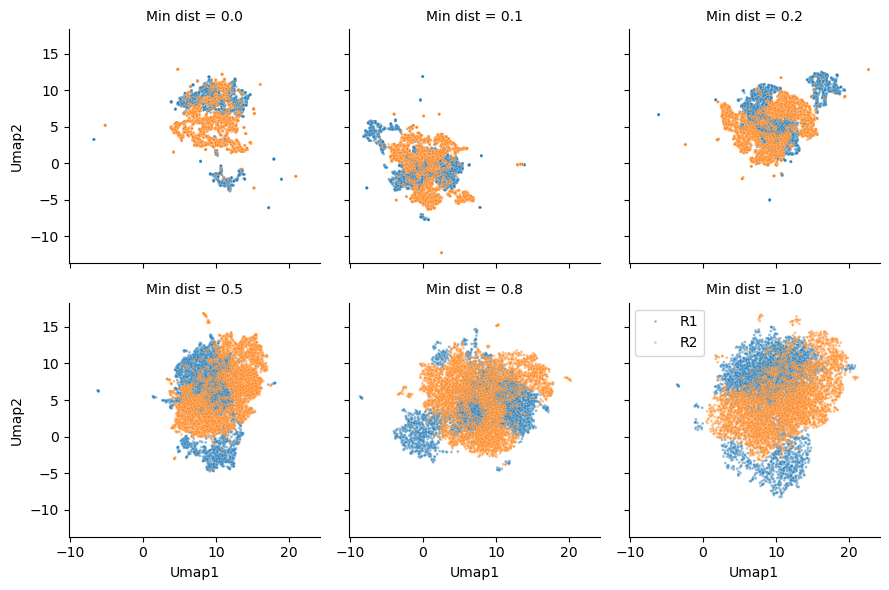

In [21]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped[mapped['Num neighbors']==5],col_wrap=3,col='Min dist')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.5)
plt.legend()

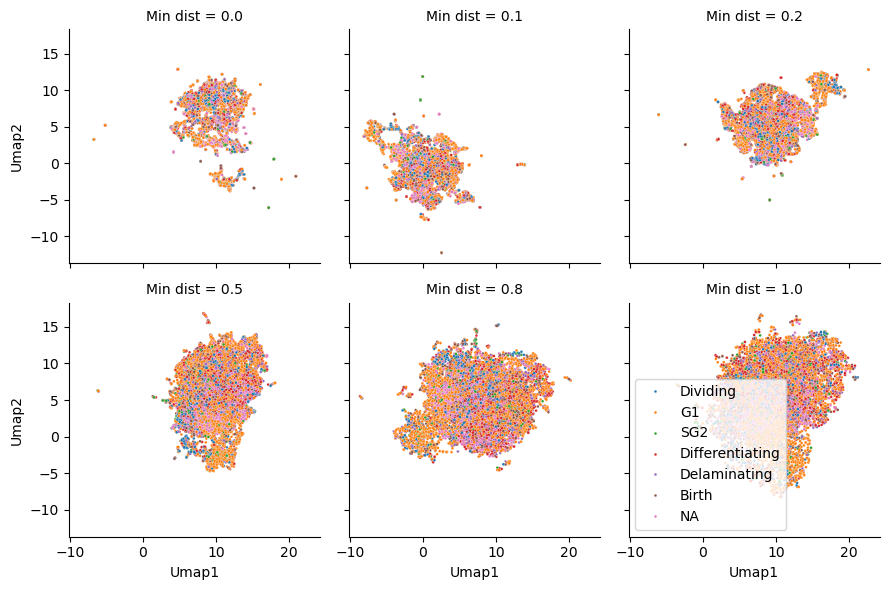

In [22]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped[mapped['Num neighbors']==5],col_wrap=3,col='Min dist')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Cell state',alpha=1)
plt.legend()

Obvious batch effects... but is it biological?

### Stability test

In [33]:
Niter = 1

_mapped = pd.DataFrame(index=scaled_data.index)
_mapped['Region'] = scaled_data['Region']
_mapped['Cell state'] = pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)['Cell cycle phase','Meta']

meta_cols = basals.xs('Meta',level=1,axis=1).columns
_df = pd.merge(scaled_data, basals[[(f,'Meta') for f in meta_cols]],left_index=True,right_index=True)

_mapped.loc[_df['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[_df['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[_df['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
_mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

mapped = []
for i in tqdm(range(Niter)):
    
    reducer = umap.UMAP(n_neighbors=5,min_dist=1)
    embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Umap run'] = i

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

  0%|                                                        | 0/1 [00:00<?, ?it/s]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/3069389067.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
100%|████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


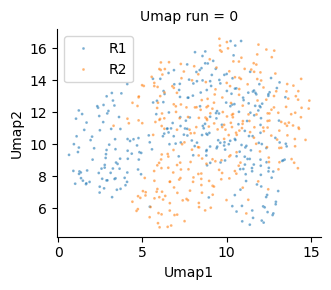

In [34]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,col_wrap=3,col='Umap run')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.6)
plt.legend()

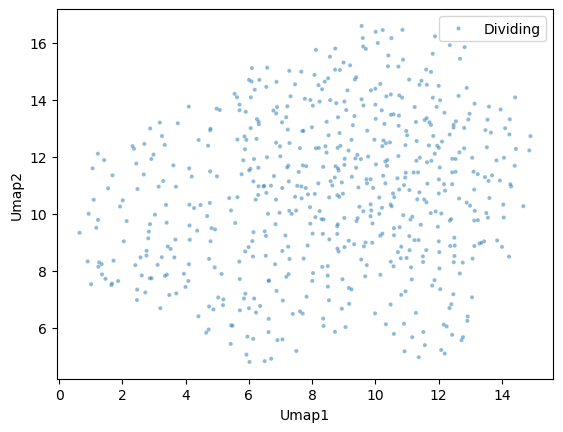

In [35]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))


Basicallly, all UMAP runs returns similar graphs

## Visualize UMAPs alongside cell state annotation

In [36]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

df = pd.merge(scaled_data, basals[[(f,'Meta') for f in meta_cols]],left_index=True,right_index=True)

df['Umap1'] = embedding[:,0]
df['Umap2'] = embedding[:,1]
df

BM height                Height to BM  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
1     R1_24                      0.394325                    1.606513   
      R1_47                     -0.370977                    0.712297   
      R1_80                      0.394325                    1.127089   
      R1_177                    -0.370977                    0.606980   
      R1_321                     0.394325                    0.997764   
...                                   ...                         ...   
13    R2_388                     1.836959                    1.343702   
      R2_529                     2.264502                    1.092899   
      R2_680                     1.409416                   -0.255221   
      R2_817                    -0.300754                    0.813606   
      R2_951                     1.409416                    2.233791   

              Mean curvature - cell coords Gaussian curvature - cell coords  \
               Measurement tissue geometry      Measurement tissue geometry   
Frame TrackID                                                                 
1     R1_24                      -2.120226                         0.421134   
      R1_47                      -0.917824                         0.914189   
      R1_80                      -2.446105                         0.381180   
      R1_177                     -1.475701                         0.443227   
      R1_321                     -1.012879                         0.571367   
...                                    ...                              ...   
13    R2_388                      0.216444                         0.854621   
      R2_529                      0.008435                         1.430192   
      R2_680                      0.443677                        -0.771005   
      R2_817                     -1.083041                        -0.072400   
      R2_951                      0.175771                         1.670819   

                       Mean curvature 2um      Gaussian curvature 2um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
1     R1_24                     -0.911962                    0.546502   
      R1_47                     -0.346458                   -0.012753   
      R1_80                     -0.659359                    0.025188   
      R1_177                    -0.535732                   -0.005498   
      R1_321                    -0.402707                    0.125074   
...                                   ...                         ...   
13    R2_388                     0.709160                   -0.507339   
      R2_529                     0.069719                   -0.325089   
      R2_680                     0.514114                   -0.688662   
      R2_817                    -1.733460                    5.288005   
      R2_951                    -0.696264                    0.325903   

                       Mean curvature 5um      Gaussian curvature 5um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
1     R1_24                     -0.947817                    1.078462   
      R1_47                     -0.647613                   -0.310206   
      R1_80                     -0.960551                   -0.114454   
      R1_177                    -0.572773                   -0.155713   
      R1_321                    -0.519024                   -0.135497   
...                                   ...                         ...   
13    R2_388                     0.421444                   -0.167655   
      R2_529                     0.003429                   -0.154149   
      R2_680                     1.259385                   -0.302369   
   

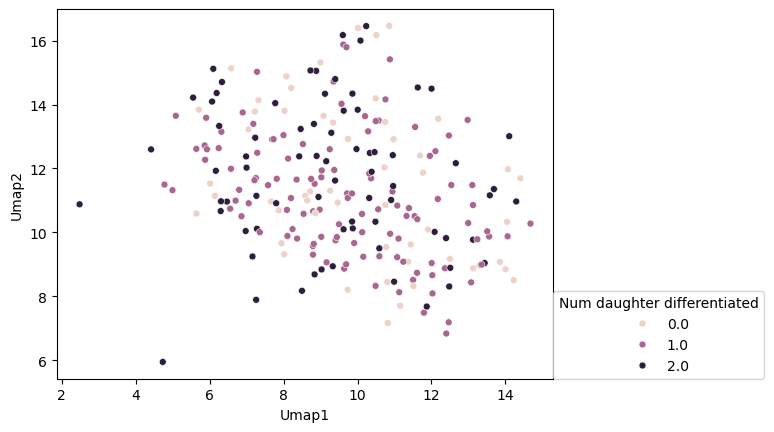

In [42]:
_df = df.droplevel(axis=1,level=1)
# _df = _df[_df['Fate known']]
ax = sb.scatterplot( _df,x='Umap1',y='Umap2',hue='Num daughter differentiated',alpha=1)
sb.move_legend(ax,[1,0])

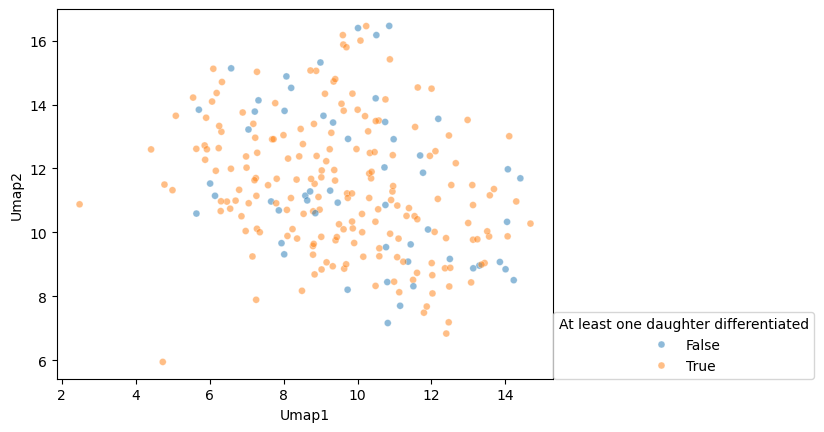

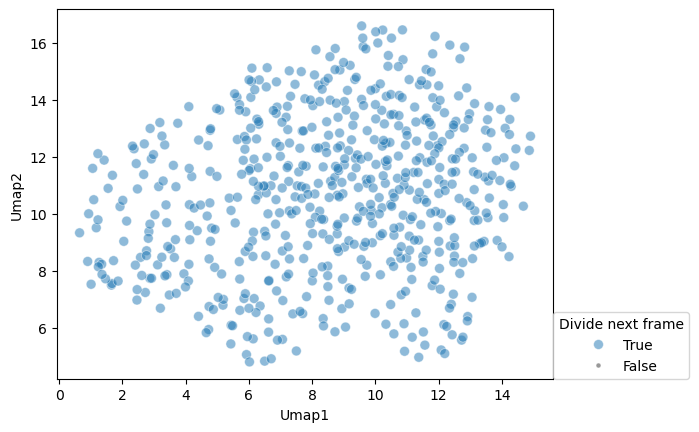

In [43]:
ax = sb.scatterplot( _df,x='Umap1',y='Umap2',hue='At least one daughter differentiated',alpha=0.5)
sb.move_legend(ax,[1,0])

plt.figure()
ax = sb.scatterplot( _df,x='Umap1',y='Umap2',hue='Divide next frame',alpha=0.5,
              size='Divide next frame', size_order=[True,False])
sb.move_legend(ax,[1,0])

# PCA

In [603]:
scaled_data

BM height                Height to BM  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -2.255796                    0.639301   
1     1                         -1.861901                    0.460889   
2     1                         -1.074109                    1.055903   
3     1                         -0.286318                    1.260528   
4     1                         -0.680214                    1.709475   
...                                   ...                         ...   
0     1166                      -1.861901                    0.758223   
      1191                      -2.649692                   -1.521773   
      1195                      -1.861901                    0.228229   
      1196                      -1.468005                    0.735781   
      1197                      -2.255796                    0.780995   

              Mean curvature - cell coords Gaussian curvature - cell coords  \
               Measurement tissue geometry      Measurement tissue geometry   
Frame TrackID                                                                 
0     1                          -1.579707                        -0.164560   
1     1                          -1.292504                         0.176855   
2     1                          -1.328134                         0.493168   
3     1                          -1.835271                        -0.015911   
4     1                          -2.049329                         0.106327   
...                                    ...                              ...   
0     1166                       -2.496556                        -0.864284   
      1191                       -1.480231                        -0.442926   
      1195                       -2.418250                        -0.736655   
      1196                       -2.579430                        -0.752901   
      1197                       -2.047841                        -0.158729   

                       Mean curvature 2um      Gaussian curvature 2um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.569460                    0.376876   
1     1                         -1.378499                    0.121699   
2     1                         -1.088642                    0.830103   
3     1                         -1.760629                    0.394366   
4     1                         -2.059485                    0.720888   
...                                   ...                         ...   
0     1166                       0.172416                    0.039280   
      1191                       1.160135                    0.102125   
      1195                      -0.528961                    0.784414   
      1196                      -1.056671                    0.611766   
      1197                       0.201162                    0.559076   

                       Mean curvature 5um      Gaussian curvature 5um  \
              Measurement tissue geometry Measurement tissue geometry   
Frame TrackID                                                           
0     1                         -1.916013                    0.599858   
1     1                         -1.713065                    0.245207   
2     1                         -1.745892                    0.252194   
3     1                         -1.283329                   -0.090297   
4     1                         -1.391225                   -0.193614   
...                                   ...                         ...   
0     1166                       0.369719                   -0.192992   
      1191                       0.885398                   -0.055703   
      1195                      -1.346061                    0.498126   
   

In [44]:
from functools import reduce

measurement_types = basals.columns.get_level_values(1)

#Intrinsics
shapes = basals.columns[ (measurement_types.str.contains('shape') | measurement_types.str.contains('shcoeff'))
                         & ~measurement_types.str.contains('adjac') & ~measurement_types.str.contains('elative')]
drop = [f for f in shapes if 'Manual' in f[0]]
shapes = shapes.drop(drop)

position = basals.columns[(measurement_types == 'Measurement cell position')]
h2b = basals.columns[(measurement_types == 'Measurement H2B') | (measurement_types == 'Measurement H2B rate')]
fucci = basals.columns[(measurement_types == 'Measurement FUCCI') | (measurement_types == 'Measurement FUCCI rate')]
intrinsic_features = reduce(list.__add__, [f.tolist() for f in [shapes,position,h2b,fucci]])

# Environment
tissue_geom = basals.columns[measurement_types.str.contains('Measurement tissue geometry')]
collagen = basals.columns[measurement_types.str.contains('ollagen')]
tissue_topo = basals.columns[measurement_types == 'Measurement topology']
adjac_shape = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('shape'))
                | (measurement_types.str.contains('adjac') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in adjac_shape if 'Manual' in f[0]]
adjac_shape = adjac_shape.drop(drop)

adjac_fucci = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('FUCCI'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('FUCCI'))]
adjac_h2b = basals.columns[(measurement_types.str.contains('adjac') & measurement_types.str.contains('H2B'))
                            | (measurement_types.str.contains('relative') & measurement_types.str.contains('H2B'))]
relative_shape = basals.columns[(measurement_types.str.contains('relative') & measurement_types.str.contains('shape'))
                                 | (measurement_types.str.contains('relative') & measurement_types.str.contains('shcoeff'))]
drop = [f for f in relative_shape if 'Manual' in f[0] or 'rate' in f[0]]
relative_shape = relative_shape.drop(drop)

extrinsic_features = reduce(list.__add__, [f.tolist() for f in [tissue_geom,collagen,tissue_topo,adjac_shape,adjac_fucci,adjac_h2b,relative_shape]])

#Other
times = basals.columns[measurement_types == 'Measurement time']
metas = basals.columns[measurement_types == 'Meta']

# Standardize
extrinsic_measurements = basals[extrinsic_features]
features2drop = extrinsic_measurements.columns[extrinsic_measurements.isna().sum() > 200]
extrinsic_measurements = extrinsic_measurements.drop(columns=features2drop)
extrinsic_measurements = extrinsic_measurements.dropna(axis=0)
extrinsic_measurements['Region'] = basals['Region']

meas_scaled_by_region = scale_by_region(extrinsic_measurements)
scaled_data = meas_scaled_by_region.dropna(axis=0)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact 

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_32818/466437022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_ = preprocessing.StandardScaler().fit_transform(scaled_data.drop(columns='Region'))


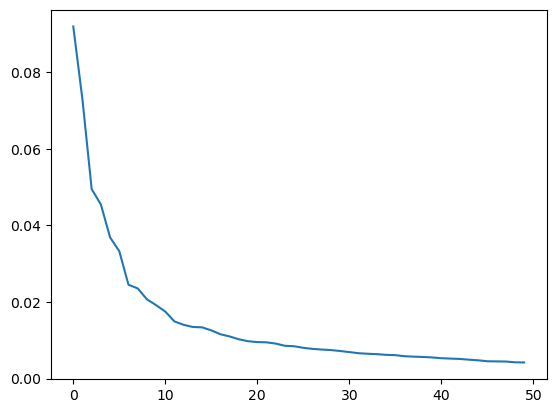

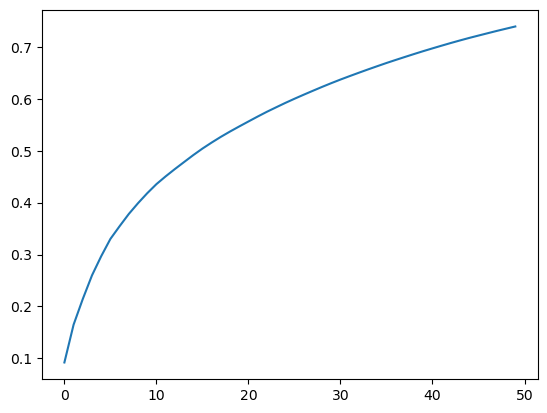

In [45]:
from sklearn import decomposition, preprocessing

N = 50

pca = decomposition.PCA(n_components=N)
X_ = preprocessing.StandardScaler().fit_transform(scaled_data.drop(columns='Region'))
X_ = pca.fit_transform(X_)
X_ = pd.DataFrame(X_,index=scaled_data.index, columns = [f'PC{i}' for i in range (N)])
X_

plt.plot(pca.explained_variance_ratio_)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

components = pca.components_
components = pd.DataFrame(components,index=[f'PC{i}' for i in range (N)],columns=scaled_data.droplevel(axis=1,level=1).columns.drop('Region')).T


([<matplotlib.axis.XTick at 0x33a187c20>,
 [Text(0, 0, 'Mean adjac BM height'),
  Text(1, 0, 'Gaussian curvature - cell coords'),
  Text(2, 0, 'Mean adjac Mean curvature - cell coords'),
  Text(3, 0, 'BM height'),
  Text(4, 0, 'Relative Total FUCCI intensity'),
  Text(5, 0, 'Height to BM'),
  Text(6, 0, 'Relative Planar component 2'),
  Text(7, 0, 'Relative Planar component 1'),
  Text(8, 0, 'Relative Cell height'),
  Text(9, 0, 'Relative Height to BM'),
  Text(10, 0, 'Relative Mean H2B intensity'),
  Text(11, 0, 'Relative Basal area'),
  Text(12, 0, 'Relative NC ratio'),
  Text(13, 0, 'Relative Distance to closest macrophage'),
  Text(14, 0, 'Collagen intensity smoothed'),
  Text(15, 0, 'Collagen intensity'),
  Text(16, 0, 'Min adjac Gaussian curvature - cell coords'),
  Text(17, 0, 'Relative Collagen intensity'),
  Text(18, 0, 'Mean curvature - cell coords'),
  Text(19, 0, 'Mean adjac shcoeff_PC4')])

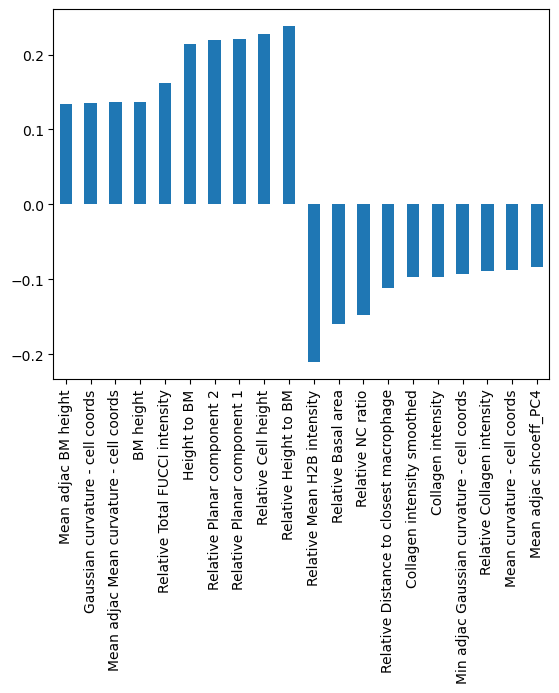

In [86]:
pc = 'PC9'

tops = pd.concat((components[pc].sort_values().tail(10),components[pc].sort_values().head(10)))
tops.plot.bar()
plt.xticks(range(20),tops.index,rotation=90)

In [47]:
_df = pd.merge(X_,basals.droplevel(axis=1,level=1)[meta_cols],left_index=True,right_index=True)

_df = _df[_df['Fate known']]

diffs = pd.Series({i:np.diff(_df.groupby('Will divide')[f'PC{i}'].mean())[0] for i in range(N)})
diffs.abs().sort_values()


39    0.000956
43    0.006746
31    0.017780
48    0.029160
46    0.033534
20    0.035064
21    0.041236
47    0.053606
19    0.055828
22    0.059703
23    0.060697
28    0.063361
38    0.095795
42    0.098434
15    0.104645
35    0.117917
49    0.119144
25    0.121745
45    0.130685
32    0.131960
40    0.134154
18    0.143034
12    0.152105
26    0.156779
36    0.168342
1     0.177644
30    0.178062
29    0.189071
44    0.190623
27    0.194029
37    0.218158
3     0.221728
33    0.236714
41    0.241259
34    0.257115
17    0.272390
10    0.276239
24    0.293267
14    0.415873
2     0.436528
0     0.441051
16    0.579344
13    0.619161
6     0.671607
4     0.890587
11    1.009888
5     1.080391
9     1.353144
7     1.457103
8     1.671527
dtype: float64

In [56]:
i = 8

print(_df.groupby('Will divide')[f'PC{i}'].mean())
components[f'PC{i}'].sort_values()


Will divide
False   -0.606914
True     1.064614
Name: PC8, dtype: float64


Min adjac BM height                   -0.104013
Mean adjac BM height                  -0.094323
Mean adjac Planar angle               -0.093579
BM height                             -0.093004
Median adjac BM height                -0.092661
                                         ...   
Relative Nuclear volume                0.239440
Relative Total FUCCI intensity         0.256996
Relative Total H2B intensity           0.284501
Relative cyto_shcoeffs_surface_area    0.285719
Relative Cell volume                   0.287400
Name: PC8, Length: 324, dtype: float64

In [79]:
components.loc['Mean curvature 5um'].abs().sort_values(ascending=False)

PC2     0.130439
PC1     0.115076
PC33    0.091021
PC9     0.077311
PC30    0.049457
PC5     0.047647
PC11    0.039934
PC13    0.039525
PC42    0.038629
PC49    0.032600
PC39    0.031644
PC12    0.031261
PC41    0.031163
PC24    0.030179
PC35    0.028190
PC8     0.027122
PC18    0.026188
PC44    0.025457
PC40    0.024032
PC10    0.023646
PC46    0.020070
PC3     0.019844
PC36    0.018415
PC48    0.017003
PC6     0.016421
PC23    0.016008
PC38    0.015669
PC45    0.014730
PC26    0.012985
PC20    0.012416
PC37    0.011953
PC28    0.011555
PC25    0.009903
PC4     0.009101
PC7     0.008709
PC27    0.008385
PC22    0.007476
PC32    0.006842
PC15    0.006074
PC0     0.005243
PC47    0.004935
PC19    0.003549
PC16    0.003540
PC14    0.003262
PC31    0.003222
PC43    0.002329
PC17    0.001259
PC21    0.001092
PC34    0.001003
PC29    0.000062
Name: Mean curvature 5um, dtype: float64

In [616]:
from scipy import stats

stats.spearmanr(diffs.abs().sort_values().index,components.loc['Mean curvature 5um'].abs().values.argsort())

SignificanceResult(statistic=np.float64(0.1847298919567827), pvalue=np.float64(0.19904216476531755))